# Import dependencies

Build a handwritten digit classifier app with TensorFlow Lite

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.6.0


# Download and explore the MNIST Dataset

The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to train our digit classification model.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit from 0 to 9, and a label identifying which digit is in the image.
![MNIST sample](https://github.com/khanhlvg/DigitClassifier/raw/master/images/mnist.png)

In [2]:
# Keras provides a handy API to download the MNIST dataset, and split them into
# "train" dataset and "test" dataset.
mnist =  keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0
print('Pixels are normalized')

Pixels are normalized


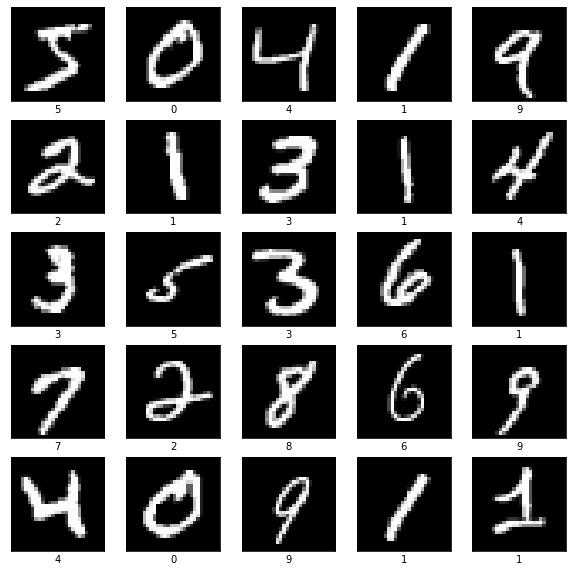

In [4]:
# Shoe the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

# Train a TensorFlow model to classify digit images

Next, we use Keras API to build a TensorFlow model and train it on the MNIST "train" dataset. After training, our model will be able to classify the digit images.

Our model takes **a 28px x 28px grayscale image** as an input, and outputs **a float array of length 10** representing the probability of the image being a digit from 0 to 9.

Here we use a simple convolutional neural network, which is a common technique in computer vision. We will not go into details about model architecture in this codelab.

In [5]:
# Define the model architecture
model = keras.Sequential(
    [
     keras.layers.InputLayer(input_shape=(28,28)),
     keras.layers.Reshape(target_shape=(28,28,1)),
     keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
     keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
     keras.layers.MaxPooling2D(pool_size=(2, 2)),
     keras.layers.Dropout(0.25),
     keras.layers.Flatten(),
     keras.layers.Dense(10)
    ]
)

# Define how to train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the digit classification model
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 17s 8ms/step - loss: 0.1376 - accuracy: 0.9580
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0538 - accuracy: 0.9833
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0391 - accuracy: 0.9883
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0315 - accuracy: 0.9901
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0260 - accuracy: 0.9914


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                9

# Evaluating the model

In [7]:
# Evaluate the model using all images in the test dataset.

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.0391 - accuracy: 0.9874
Test Accuracy: 0.9873999953269958


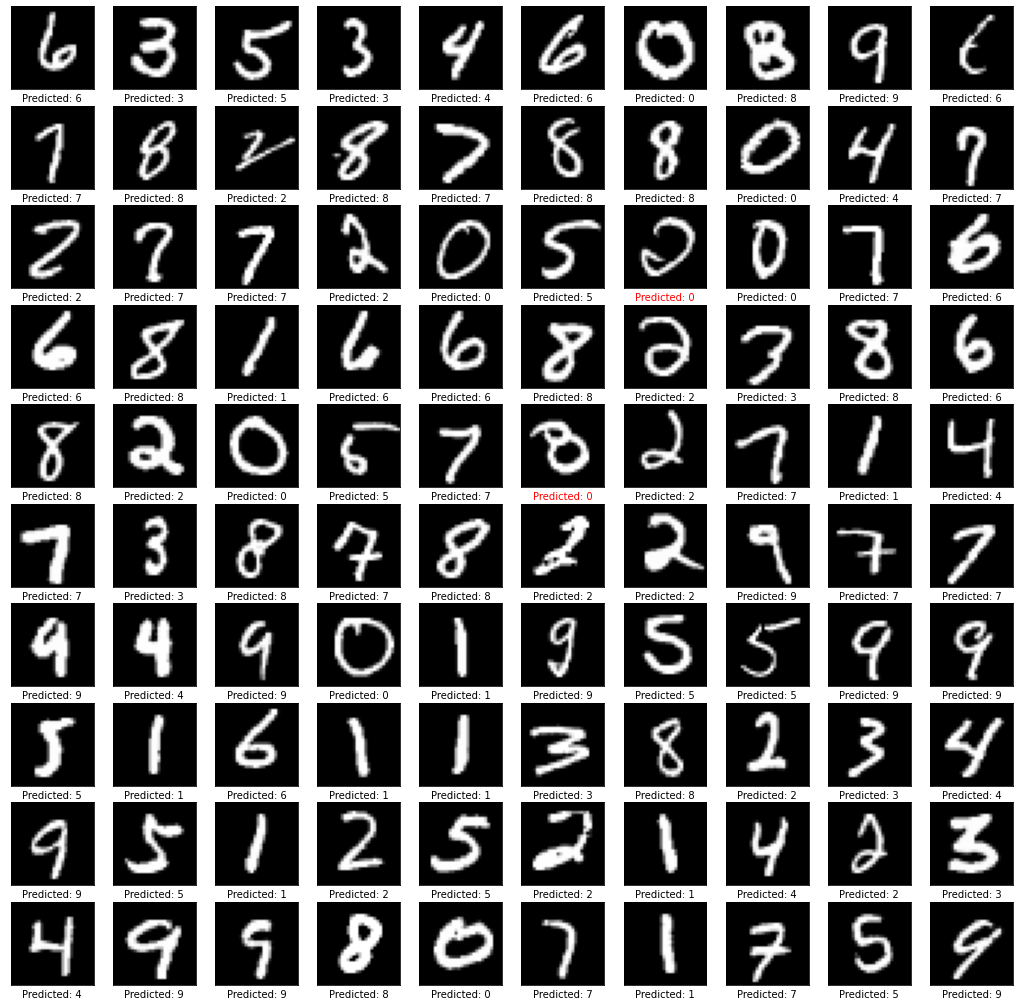

In [8]:
# A helper function that returns 'red/black' depending on if its two input
# parameter matches or not.

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
prediction_digits = np.argmax(predictions, axis=1)

# The plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in the red color.

plt.figure(figsize=(18,18))
for i in range(100):
  ax = plt.subplot(10,10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index], \
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

# Convert the Keras model to TensorFlow Lite

Now as we have trained the digit classifier model, we will convert it to TensorFlow Lite format for mobile deployment.

In [9]:
# Convert Keras Model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float Model Size = %dKBs.' % float_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpapj01f3z/assets
Float Model Size = 436KBs.


As we will deploy our model to a mobile device, we want our model to be as small and as fast as possible. **Quantization** is a common technique often used in on-device machine learning to shrink ML models. Here we will use 8-bit number to approximate our 32-bit weights, which in turn shrinks the model size by a factor of 4.

In [10]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

INFO:tensorflow:Assets written to: /tmp/tmprrsbos7y/assets


INFO:tensorflow:Assets written to: /tmp/tmprrsbos7y/assets


Quantized model size = 114KBs,
which is about 26% of the float model size.


# Evaluate the TensorFlow Lite Model

By using quantization, we often traded off a bit of accuracy for the benefit of having a significantly smaller model. Let's calculate the accuracy drop of our quantized model

In [11]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))

Float model accuracy = 0.9874
Quantized model accuracy = 0.9873
Accuracy drop = 0.0001


# Download the TensorFlow Lite Model

Let's get our model and integrate it into an Android App

In [12]:
# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

print('`mnist.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`mnist.tflite` has been downloaded
